# Working on Adult Dataset

### Doing necessary imports

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Reading Data from CSV file

For reading the dataset we didn't have a .csv file this time so for the columns we had old.adult.names and for the dataset we had adult.data and adult.test as in training dataset and test dataset. For this we'll read adult.names file and keep it in columns. Then we'll read data and put in a dataset. Afterwards we'll declare columns.

In [2]:
with open('/content/old.adult.names', 'r') as file:
    columns = [line.split(':')[0].strip() for line in file]

df_data = pd.read_csv('/content/adult.data', header=None)
df_test = pd.read_csv('/content/adult.test', header=None)

df = pd.concat([df_data, df_test], ignore_index=True)
df.columns = columns
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Preprocessing

In [3]:
df.shape

(48842, 15)

### Checking to see any NaN values

In [4]:
df.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
class             False
dtype: bool

### Using Label Encoder

Models can only be trained on Numerical Values. Due to this limitation, we have to use libaries that encode words into values that can be evaluated.

For this we have multiple options:
1) Label Encoder
2) One Hot Encoder
3) Panda's get dummies function

We'll be using Label Encoder. This is so because we wish to implement this on 'Sex' and 'Embarked' column which has only two categorical labels so Label encoder will convert the labels into integer and create a single column.

In [5]:
label_encoder = LabelEncoder()
df['workclass'] = label_encoder.fit_transform(df.workclass)
df['education'] = label_encoder.fit_transform(df.education)
df['marital-status'] = label_encoder.fit_transform(df['marital-status'])
df['occupation'] = label_encoder.fit_transform(df.occupation)
df['relationship'] = label_encoder.fit_transform(df.relationship)
df['race'] = label_encoder.fit_transform(df.race)
df['sex'] = label_encoder.fit_transform(df.sex)
df['native-country'] = label_encoder.fit_transform(df['native-country'])
df['class'] = label_encoder.fit_transform(df['class'])

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


### Scaling down the columns

We'll be using MinMax Scalar to scale down the 'Age' Column to get a better fit model.

In [6]:
minMax = MinMaxScaler()
minMax.fit(df[['fnlwgt']])
df.fnlwgt = minMax.transform(df[['fnlwgt']])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,7,0.044131,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,0.048052,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,0.137581,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,0.150486,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,0.220635,9,13,2,10,5,2,0,0,0,40,5,0


### Seperating Dataset as X and Y values

In [7]:
X = df.drop(['class'],axis='columns')
Y = df['class']

## Visualizing Dataset

For this We can use:
1) Seaborn
2) MatplotLib

We'll be using Matplotlib library to plot and see the database to decide which columns to drop.

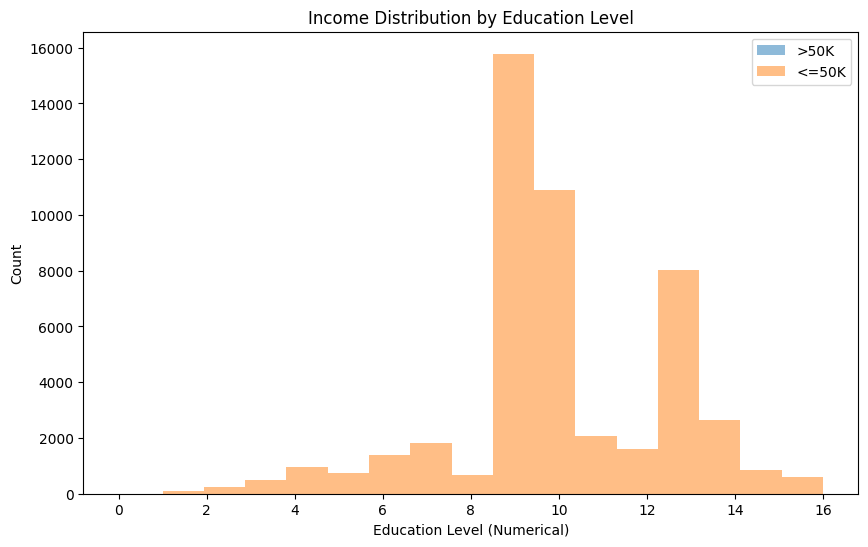

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['class'] == '>50K']['education-num'], alpha=0.5, label='>50K', bins=16)
plt.hist(df[df['class'] != '>50K']['education-num'], alpha=0.5, label='<=50K', bins=16)

plt.xlabel('Education Level (Numerical)')
plt.ylabel('Count')
plt.title('Income Distribution by Education Level')
_ = plt.legend()

## Selecting the best model and Hyperparameter Tuning

As taught in Week 4, We'll be using RandomizedSearchCV to find the best hyperparameter for the model. It is because the dataset is large so searching through all the parameters will take a lot of time and be inefficient.

As this is Classification after looking at the graph, We'll be testing on the following 2 models:
1) KNN Regression
2) XG Boost

### Using KNN Means

In [18]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = RandomizedSearchCV(KNeighborsClassifier(), {}, cv=5, scoring='accuracy')
grid_search.fit(X, Y)
grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.5083125858435512

### Using XGBoost

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

y_train = np.clip(y_train, 0, 2)
y_test = np.clip(y_test, 0, 2)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 6,
    'eta': 0.3,
}

num_round = 100
bst = xgb.train(params, dtrain, num_round)

preds = bst.predict(dtest)

accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6303613471184358
